In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import random
import pickle
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

In [5]:
def get_targets_with_weights(batch_data, initial_ensembles, size_ens, ann): 
    
    target_dim = 1
    
    weights_ann_1 = ann.get_weights()
    
    h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [6]:
def ann(hidden = 32, input_shape = 256, output_shape = 1): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(output_shape, activation = "relu")
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [7]:
def generate_initial_ensembles(num_weights, lambda1, size_ens):
    mean_vec = np.zeros((num_weights,))
    cov_matrix = lambda1*np.identity(num_weights)
    mvn_samp = mvn(mean_vec, cov_matrix)
    return mvn_samp.rvs(size_ens)

In [8]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [9]:
hidden_neurons = 16

In [10]:
def get_initial_X_t(data1, data2, size_ens, var_weights = 0.1):
    samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    
    initial_ensembles1 = generate_initial_ensembles(samp_ann.count_params(), var_weights, size_ens)
    data1_out1, data1_stack1 = get_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens, ann = samp_ann)
    
    initial_ensembles2 = generate_initial_ensembles(samp_ann.count_params(), var_weights, size_ens)
    data1_out2, data1_stack2 = get_targets_with_weights(data1, initial_ensembles2, size_ens = size_ens, ann = samp_ann)
    
    initial_ensembles3 = generate_initial_ensembles(samp_ann.count_params(), var_weights, size_ens)
    data2_out1, data2_stack1 = get_targets_with_weights(data2, initial_ensembles3, size_ens = size_ens, ann = samp_ann)
    
    initial_ensembles4 = generate_initial_ensembles(samp_ann.count_params(), var_weights, size_ens)
    data2_out2, data2_stack2 = get_targets_with_weights(data2, initial_ensembles4, size_ens = size_ens, ann = samp_ann)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles_for_weights = generate_initial_ensembles(4, var_weights, size_ens)
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    initial_ensembles_for_L = generate_initial_ensembles(4, var_weights, size_ens)
    initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)    
    
    initial_ensembles_for_D1 = generate_initial_ensembles(1, var_weights, size_ens).reshape(-1,1)
    initial_ensembles_for_D2 = generate_initial_ensembles(1, var_weights, size_ens).reshape(-1,1)
    
    initial_ensembles_for_D1_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    initial_ensembles_for_D2_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D = np.concatenate((np.expand_dims(initial_ensembles_for_D1,1),
                                                       np.expand_dims(initial_ensembles_for_D1_zero,1), 
                                                      np.expand_dims(initial_ensembles_for_D2,1),
                                                       np.expand_dims(initial_ensembles_for_D2_zero,1)), axis = 2)
    
    # print(X_t.shape, initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D), axis = 1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4))
    
    return X_t, initial_ensembles, initial_ensembles_for_weights[:,0,:], initial_ensembles_for_L[:,0,:], initial_ensembles_for_D[:,0,:]

In [11]:
def get_weighted_targets_with_weights(batch_data, initial_ensembles, size_ens, ann, weights): 
    
    target_dim = 1
    
    weights_ann_1 = ann.get_weights()
    
    h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    final_output_1 = final_output_1*weights
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [12]:
alogp_bottleneck = np.load("..//Data/small_mol_phase_3_features_for_both.npy")

In [13]:
y_valid = pd.read_csv("..//Data/smiles_with_rdkit_with_small_phase_3_outputs.csv")

In [14]:
std_targets = pickle.load( open('..//Data//target_scaler.pkl', 'rb'))

/home/statgrads/vpiyush2/.conda/envs/enkf/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [15]:
y_train = y_valid.values[:,1:]

In [16]:
y_train = std_targets.transform(y_train)

/home/statgrads/vpiyush2/.conda/envs/enkf/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
x_train, x_valid, y_train, y_valid = train_test_split(alogp_bottleneck, y_train, test_size = 0.25, shuffle = True, 
                                                     random_state = 42)

In [19]:
x_train.shape

(719, 64)

In [20]:
smiles_feats_train = x_train[:, :32]

In [21]:
rdkit_feats_train = x_train[:, 32:]

In [22]:
smiles_feats_valid = x_valid[:, :32]
rdkit_feats_valid = x_valid[:, 32:]

In [23]:
# size_ens = 250

In [24]:
def forward_operation(data1, data2, combined_ensembles , size_ens ):
    samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann.count_params()
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (4*params):(4*params + 4)]
    
    initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(4*params + 4 + 4):(4*params + 4 + 4 + 4)]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:,:2].sum(1).reshape(-1,1)
    
    model_2 = softmax_weights[:,2:].sum(1).reshape(-1,1)
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                 ann = samp_ann, weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data1, initial_ensembles2, size_ens = size_ens,
                                                                 ann = samp_ann, weights=model_1)
    
    data2_out1, data2_stack1 = get_weighted_targets_with_weights(data2, initial_ensembles3, size_ens = size_ens,
                                                                 ann = samp_ann, weights=model_2)
    
    data2_out2, data2_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles4, size_ens = size_ens,
                                                                 ann = samp_ann, weights=model_2)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4, 
                        initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D), axis = 1)
    
    weighted_alogp = data1_out1 + data2_out1
    
    weighted_psa = data1_out2 + data2_out2
    
    return X_t, initial_ensembles, weighted_alogp, weighted_psa, model_1, model_2

In [25]:
samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)

In [26]:
samp_ann.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 545
Trainable params: 545
Non-trainable params: 0
_________________________________________________________________


In [27]:
samp_ann.count_params()

545

In [23]:
total_weights = 4*(samp_ann.count_params() + 1 + 1 + 1)

In [24]:
total_weights

2192

In [25]:
reduction = 8

In [26]:
size_ens = total_weights//reduction

In [27]:
size_ens

274

In [28]:
X_t, initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D = get_initial_X_t(smiles_feats_train, rdkit_feats_train, size_ens = size_ens)

In [29]:
# X_t, initial_ensembles, initial_ensembles_for_weights = get_initial_X_t(smiles_feats_train, rdkit_feats_train, size_ens = size_ens)

In [30]:
initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D))

In [31]:
initial_ensembles.shape

(274, 2192)

In [32]:
G_t = [[1, 0, 1, 0], [0, 1, 0, 1]]
G_t = np.array(G_t).T

In [33]:
G_t

array([[1, 0],
       [0, 1],
       [1, 0],
       [0, 1]])

In [34]:
def get_predictions(data1, data2, initial_ensembles): 
    _,_, weighted_alogp, weighted_psa, w1, w2 = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens)
    weighted_alogp = np.expand_dims(weighted_alogp,-1)
    weighted_psa = np.expand_dims(weighted_psa,-1)
    preds = np.concatenate((weighted_alogp, weighted_psa),-1)
    return preds, w1, w2

In [35]:
# H_t = np.hstack((np.identity(smiles_feats_train.shape[0]), np.zeros((smiles_feats_train.shape[0], samp_ann.count_params() + 1 + 1 + 1))))

In [36]:
# H_t.shape

In [37]:
def calculate_mu_bar_G_bar(data1, data2, initial_ensembles):
    H_t = np.hstack((np.identity(data1.shape[0]), np.zeros((data1.shape[0], samp_ann.count_params() + 1 + 1 + 1))))
    mu_bar = initial_ensembles.mean(0)
    X_t,_, _, _, _, _ = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens)
    X_t = X_t.transpose((0,2,1))
    X_t = X_t.reshape(X_t.shape[0], X_t.shape[1]*X_t.shape[2])
    script_H_t = np.kron(G_t.T, H_t)
    G_u = (script_H_t@X_t.T)
    G_u = G_u.T
    # weighted_alogp = np.expand_dims(weighted_alogp,-1)
    # weighted_psa = np.expand_dims(weighted_psa,-1)
    # G_u = np.concatenate((weighted_alogp, weighted_psa), axis = -1)
    # G_u = G_u.transpose((0,2,1))
    # G_u = G_u.reshape(G_u.shape[0], G_u.shape[1]*G_u.shape[2])
    # G_u
    G_bar = (G_u.mean(0)).ravel()
    return mu_bar.reshape(-1,1), G_bar.reshape(-1,1), G_u

In [38]:
def calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u): 
    u_j_minus_u_bar = initial_ensembles - mu_bar.reshape(1,-1)
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    c = np.zeros((total_weights, G_bar.shape[0]))
    for i in range(0, size_ens): 
        c += np.kron(u_j_minus_u_bar[i, :].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return c/size_ens, G_u_minus_G_bar

In [39]:
def calculate_D_u( G_bar, G_u): 
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    d = np.zeros((G_bar.shape[0], G_bar.shape[0]))
    for i in range(0, size_ens): 
        d += np.kron(G_u_minus_G_bar[i,:].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return d/size_ens

In [40]:
# initial_ensembles.shape

In [41]:
def get_updated_ensemble(data1, data2, initial_ensembles, size_ens = size_ens):
    mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(data1, data2, initial_ensembles)
    C, G_u_minus_G_bar = calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u)
    D = calculate_D_u( G_bar, G_u)
    _, R_t = create_cov(data1.shape[0],initial_ensembles)
    # all_covs = np.array(all_covs)
    D_plus_cov = D + R_t
    D_plus_cov_inv = np.linalg.inv(D_plus_cov)
    mid_quant = C@D_plus_cov_inv
    noise_vec_mean = np.zeros((R_t.shape[0], ))
    noise_mvn = mvn(noise_vec_mean, R_t)
    fudging = noise_mvn.rvs(size_ens)
    interim = (y_train.T.flatten().reshape(1,-1) + fudging)
    right_quant = interim - G_u
    # print(mid_quant.shape, right_quant.shape)
    mid_times_right = mid_quant@right_quant.T
    updated_ensemble = (initial_ensembles + mid_times_right.T)
    return updated_ensemble

In [42]:
# initial_ensembles[:, -8:-4].mean(0)

In [43]:
target_dim = 2

In [44]:
# initial_ensembles[:, -4:]

In [45]:
# tf.math.softplus(np.array([0.]).reshape(-1,1))

In [46]:
def create_cov(shape, initial_ensembles):
    cov_part = initial_ensembles[:, -8:-4]
    cov_part = cov_part.mean(0)
    # variances = tf.math.softplus(cov_part[:2]).numpy()
    variances = cov_part[:2]
    covariances = cov_part[2:]
    base_cov = np.identity(target_dim)
    base_cov[0,0] = variances[0]
    base_cov[1,1] = variances[1]
    base_cov[0,1] = covariances[0]
    base_cov[1,0] = covariances[1]
    
    variances1 = tf.math.softplus(initial_ensembles[:, -4:]).numpy()
    variances1 = variances1.mean(0)
    base_variances = np.identity(target_dim)
    base_variances[0,0] = variances1[0]
    base_variances[1,1] = variances1[2]
    
    # final = np.linalg.cholesky(base_cov@base_cov.T + base_variances)
    final = base_cov@base_cov.T + base_variances
    cov_mat = final
    cov_mat_final = cov_mat
    # cov_mat_final = cov_mat@cov_mat.T
    
    if is_pos_def(cov_mat_final) != True:
        print("resulting cov matrix is not positive semi definite")
        pass
    
    # print(np.linalg.det(cov_mat_final))
    
    var1 = cov_mat_final[0,0]
    var2 = cov_mat_final[1,1]
    cov = cov_mat_final[1,0]

    n = shape
    
    ul = var1*np.identity(n)
    lr = var2*np.identity(n)
    ur = cov*np.identity(n)
    ll = ur.T    
    
    first_row = np.hstack((ul, ur))
    second_row = np.hstack((ll, lr))
    
    R_t = np.vstack((first_row, second_row))
    
    # R_t = block_diag(*([cov_mat_final] * n))
    
    # R_t = np.linalg.inv(R_t)
    
    return cov_mat_final, R_t
    

In [47]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [48]:
cov_mat_final, _ = create_cov(smiles_feats_train.shape[0],initial_ensembles)

In [49]:
cov_mat_final

array([[7.22152169e-01, 6.42191697e-05],
       [6.42191697e-05, 7.03437989e-01]])

In [50]:
def inverse_transform(data, idx):
    data_cur = data[idx, :, :]
    inv_data_cur = std_targets.inverse_transform(data_cur)
    return inv_data_cur

In [51]:
from joblib import Parallel, delayed

In [52]:
from scipy.linalg import norm

In [53]:
initial_ensembles.shape

(274, 2192)

In [54]:
# from tqdm.notebook import trange

In [55]:
# rmse_train

In [56]:
y_chk_full = pd.read_csv("..//Data/y_train.csv")

In [57]:
y_chk_full.shape

(1694445, 2)

In [58]:
np.cov(y_chk_full.values.T)

array([[   3.56194622,  -24.68021802],
       [ -24.68021802, 1862.41330966]])

In [59]:
# c = np.zeros((2,2))

In [60]:
# c = c/size_ens

In [61]:
# c

In [62]:
from scipy.stats import pearsonr

In [63]:
# coverage_train

In [64]:
# w2 + w1

In [65]:
# w1

In [66]:
np.cov(std_targets.inverse_transform(y_train).T)

array([[   7.15535584,  -59.64784375],
       [ -59.64784375, 3085.51412811]])

In [67]:
w1_catch = []
w2_catch = []
w1_sd_catch = []
w2_sd_catch = []
weight_norm_mean = []
weight_norm_sd = []

best_rmse = 10000
patience = 0
for i in range(0,10000):
    c = np.zeros((2,2))
    initial_ensembles = get_updated_ensemble(smiles_feats_train, rdkit_feats_train, initial_ensembles)
    G_u_train, w1, w2 = get_predictions(smiles_feats_train, rdkit_feats_train, initial_ensembles)
    
    w1_catch.append(w1.mean())
    w1_sd_catch.append(w1.std())
    
    w2_catch.append(w2.mean())
    w2_sd_catch.append(w2.std())  
    
    print("Epoch " + str(i+1))
    
    
    print("Averaging Weight with SD")
    print([w1.mean(), w1.std()])
    print([w2.mean(), w2.std()])
    
    # G_u_train = get_targets_with_weights(smiles_feats_train, rdkit_feats_train, initial_ensembles, size_ens = size_ens)
    catch = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(G_u_train, i)  for i in range(G_u_train.shape[0]))
    G_u_train = np.array(catch)
    
    y_train_cur = std_targets.inverse_transform(y_train)
    
    li_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[0,:,:]   
    ui_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[1,:,:]
    
    width_train = ui_train - li_train
    avg_width_train = width_train.mean(0)
    
    ind_train = (y_train_cur >= li_train) & (y_train_cur <= ui_train)
    coverage_train= ind_train.mean(0)
    
    averaged_targets_train = G_u_train.mean(0)
    rmse_train = np.sqrt(((y_train_cur -averaged_targets_train)**2).mean(0))
    # print(rmse_train, coverage_train, avg_width_train)
    pearson_train_alogp = pearsonr(y_train_cur[:,0], averaged_targets_train[:,0])[0]
    pearson_train_psa = pearsonr(y_train_cur[:,1], averaged_targets_train[:,1])[0]
    
    G_u_test, _, _ = get_predictions(smiles_feats_valid, rdkit_feats_valid, initial_ensembles)
    
    catch = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(G_u_test, i)  for i in range(G_u_test.shape[0]))
    G_u_test = np.array(catch)
    
    y_valid_cur = std_targets.inverse_transform(y_valid)    
    
    li_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[0,:,:]   
    ui_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[1,:,:]
    
    width_test = ui_test - li_test
    avg_width_test = width_test.mean(0)
    
    ind_test = (y_valid_cur >= li_test) & (y_valid_cur <= ui_test)
    coverage_test= ind_test.mean(0)
    
    averaged_targets_test = G_u_test.mean(0)
    rmse_test = np.sqrt(((y_valid_cur -averaged_targets_test)**2).mean(0))    
    
    pearson_test_alogp = pearsonr(y_valid_cur[:,0], averaged_targets_test[:,0])[0]
    pearson_test_psa = pearsonr(y_valid_cur[:,1], averaged_targets_test[:,1])[0]
    
    weight_norms = np.array(norm(initial_ensembles, ord = 2, axis = 1))
    weight_norm_mean.append(weight_norms.mean())
    weight_norm_sd.append(weight_norms.std())
    
   
    print("Weight Norms")
    print([weight_norms.mean(), weight_norms.std()])
    
    
    # if np.mean(coverage_train < 0.95) == 1:
    #     break
        
    cov_mat_final, _ = create_cov(smiles_feats_train.shape[0],initial_ensembles)
    
    print("standardized_scale_R_t")
    print(np.diag(cov_mat_final), cov_mat_final[0,1])
    
    print("Train RMSEs, Pearson ,Coverages, and Widths")
    print(rmse_train, [pearson_train_alogp, pearson_train_psa] ,coverage_train, avg_width_train)
    
    print("Test RMSEs, Pearson , Coverages, and Widths")
    print(rmse_test, [pearson_test_alogp, pearson_test_psa] , coverage_test, avg_width_test)
    

    
    
    
    value = rmse_train.mean()
    
    for i in range(0, size_ens):
        c+= np.cov(G_u_train[i,:,:].T)
        
    c = c/(size_ens)    
    
    
    if (value < best_rmse) & (coverage_train.mean() >= 0.95): 
        best_rmse = value
        best_rmse_train = rmse_train
        best_coverage = coverage_train
        best_width = avg_width_train
        patience = 0
        best_rmse_test = rmse_test
        best_coverage_test = coverage_test
        best_width_test = avg_width_test
        best_R_t = c
        best_pearsonr_train = [pearson_train_alogp, pearson_train_psa]
        best_pearsonr_test = [pearson_test_alogp, pearson_test_psa]
        best_initial_ensembles = initial_ensembles
        best_G_u_test = G_u_test
        best_averaged_targets_test = averaged_targets_test
        best_mod1_weight = w1.mean()
        best_mod2_weight = w2.mean()
        best_train_metrics = [best_rmse_train, best_coverage, best_width, best_pearsonr_train]
        best_test_metrics = [best_rmse_test, best_coverage_test, best_width_test, best_pearsonr_test]
        # print(['i', 'best_rmse', 'best_coverage', 'best_rmse_test', 'best_coverage_test', 'best_R_t'])
        # print([i, best_rmse, best_coverage, best_rmse_test, best_coverage_test, best_R_t])
    else:
        patience +=1 
    
    print("data_scale_R_t")
    print(c)
        
    print('patience')
    print(patience)
    
    print("\n")    
    
        
    if patience >= 20:
        break
    

Epoch 1
Averaging Weight with SD
[0.5360946968822943, 0.06852472471733882]
[0.4639053031177058, 0.06852472471733882]
Weight Norms
[14.253375916961177, 0.6488802932753422]
standardized_scale_R_t
[0.76753221 0.80355457] -0.007995672943792428
Train RMSEs, Pearson ,Coverages, and Widths
[ 2.94993377 47.87654726] [0.05619857607731011, 0.5418991200425375] [1. 1.] [ 13.52271473 291.94035546]
Test RMSEs, Pearson , Coverages, and Widths
[ 2.90663592 42.75351622] [0.03398824783786059, 0.5961309534746075] [1. 1.] [ 13.32268541 290.10479992]
data_scale_R_t
[[  17.34219743   -8.74763773]
 [  -8.74763773 8540.39087436]]
patience
0


Epoch 2
Averaging Weight with SD
[0.5684992767864894, 0.06215019153270371]
[0.4315007232135106, 0.0621501915327037]
Weight Norms
[14.356429347825115, 0.6493071325233175]
standardized_scale_R_t
[0.73056045 0.88483276] -0.014478018314356182
Train RMSEs, Pearson ,Coverages, and Widths
[ 2.35959288 45.09046565] [0.6510148355166079, 0.5849146316373572] [0.99443672 0.99721836]

In [68]:
# value

In [69]:
G_u_test.shape

(274, 240, 2)

In [29]:
w1_catch = pickle.load (open('..//Data//best_w1_catch_applications_no_cholesky.pkl', 'rb'))

In [ ]:
# pickle.dump(w1_sd_catch, open('..//Data//best_w1_sd_catch_applications_no_cholesky.pkl', 'wb'))

In [30]:
w1_sd_catch = pickle.load (open('..//Data//best_w1_sd_catch_applications_no_cholesky.pkl', 'rb'))

In [31]:
best_initial_ensembles = pickle.load(open('..//Data//best_initial_ensembles_applications_no_cholesky.pkl', 'rb'))

In [41]:
best_G_u_test = pickle.load(open('..//Data//G_u_test_applications_no_cholesky.pkl', 'rb'))

In [ ]:
# pickle.dump(best_initial_ensembles, open('..//Data//best_initial_ensembles_applications_no_cholesky.pkl', 'wb'))

In [34]:
best_averaged_targets_test = pickle.load(open('..//Data//best_averaged_targets_test_applications_no_cholesky.pkl', 'rb'))

In [37]:
y_valid_cur = pickle.load(open('..//Data//y_valid_cur_applications_no_cholesky.pkl', 'rb'))

In [36]:
# best_averaged_targets_test

In [38]:
import random

In [43]:
random_idx = random.sample(range(y_valid_cur.shape[0]), k = 4)

/tmp/ipykernel_2249363/3204971427.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx, 0].set_yticklabels(axs[idx, 0].get_yticks().round(2), weight='bold', )
/tmp/ipykernel_2249363/3204971427.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx, 0].set_xticklabels(axs[idx, 0].get_xticks().round(2), weight='bold')
/tmp/ipykernel_2249363/3204971427.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx, 1].set_yticklabels(axs[idx, 1].get_yticks().round(2), weight='bold')
/tmp/ipykernel_2249363/3204971427.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx, 1].set_xticklabels(axs[idx, 1].get_xticks().round(2), weight='bold')


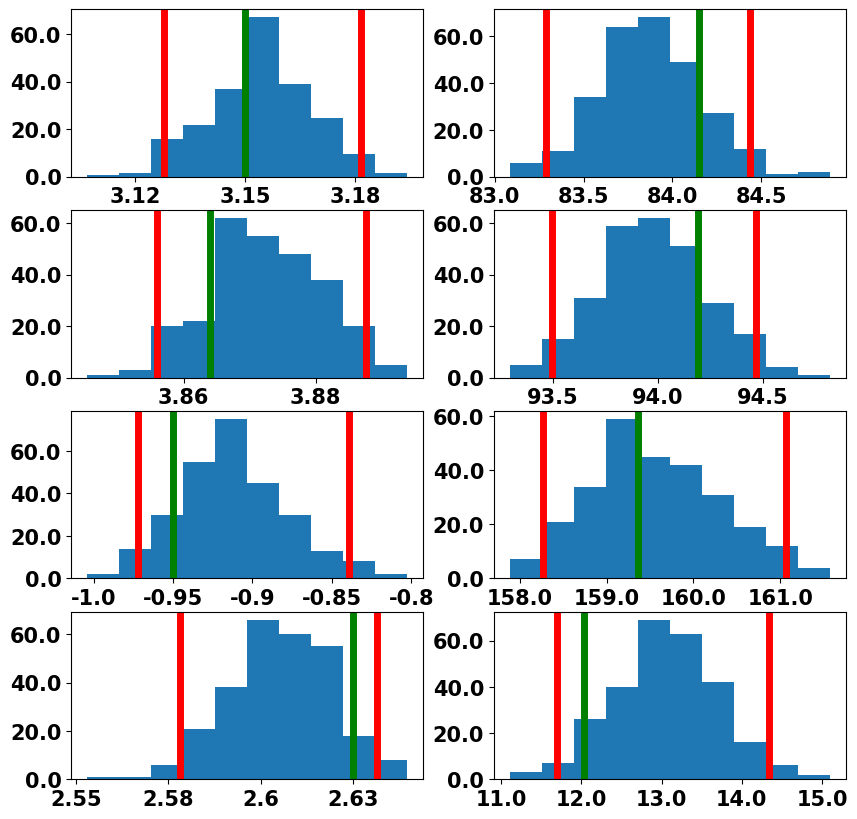

In [107]:
fig, axs = plt.subplots(4, 2,figsize=(10, 10))
# axs = axs.ravel()
counter = 0
for idx, i in enumerate(random_idx):
    # i = counter
    # print(counter)
    truth = y_valid_cur[i,:]
    preds = best_G_u_test[:, i,:]
    percts = np.percentile(preds, axis = 0, q = (2.5, 97.5))
    lis = percts[0,:]
    uis = percts[1,:]
    
    
    axs[idx, 0].hist(preds[:,0])
    axs[idx, 0].axvline(truth[0], color='green', linewidth=5)
    axs[idx, 0].axvline(lis[0], color='red', linewidth=5)
    axs[idx, 0].axvline(uis[0], color='red', linewidth=5)
    axs[idx, 0].set_yticklabels(axs[idx, 0].get_yticks().round(2), weight='bold', )
    axs[idx, 0].set_xticklabels(axs[idx, 0].get_xticks().round(2), weight='bold')
    axs[idx, 0].tick_params(axis='both', labelsize=15)
    
    axs[idx, 1].hist(preds[:,1])
    axs[idx, 1].axvline(truth[1], color='green', linewidth=5)
    axs[idx, 1].axvline(lis[1], color='red', linewidth=5)
    axs[idx, 1].axvline(uis[1], color='red', linewidth=5)
    axs[idx, 1].set_yticklabels(axs[idx, 1].get_yticks().round(2), weight='bold')
    axs[idx, 1].set_xticklabels(axs[idx, 1].get_xticks().round(2), weight='bold')
    axs[idx, 1].tick_params(axis='both', labelsize=15)
    
    counter+=1
    # counter+=2
    # print(counter)
    
    # plt.show()
# plt.xticks(weight = 'bold')
fig.savefig('Plots/prediction_intervals_Smiles_Rdkit_MEnKF_MultiOutput.pdf', bbox_inches='tight', format = "pdf")
fig.savefig('Plots/prediction_intervals_Smiles_Rdkit_MEnKF_MultiOutput.png', bbox_inches='tight')
# plt.savefig('Plots//prediction_intervals_.png', bbox_inches='tight')

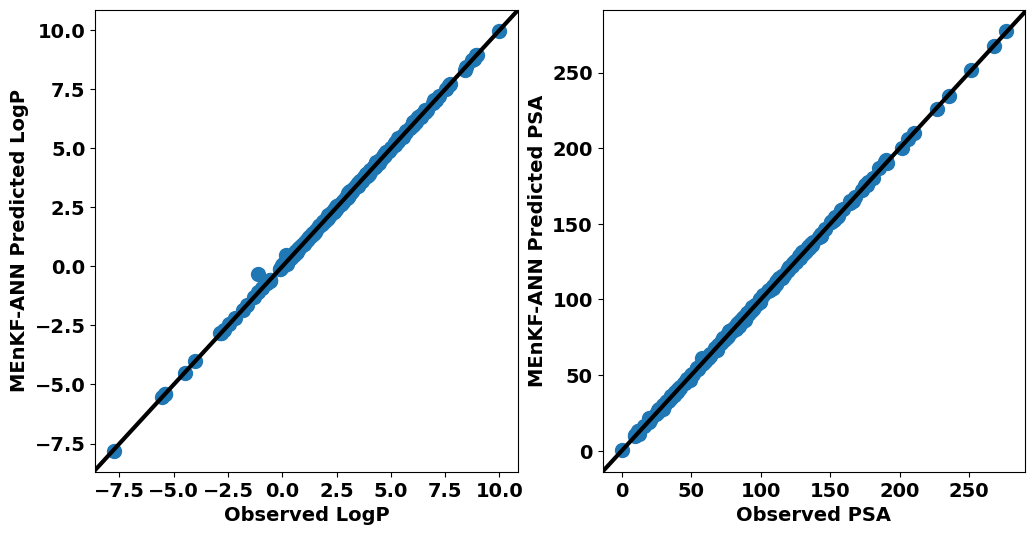

In [108]:
fig, axs = plt.subplots(1, 2,figsize=(12, 6))
# fig, axs = plt.subplots(4, 2)
axs = axs.ravel()
axs[0].scatter(y_valid_cur[:, 0], best_averaged_targets_test[:,0], s = 100)
axs[0].axline((0,0), slope = 1, c= "black", linewidth = 3)
# axs[0].fill_between(range(0,len_updates), rmse_at_each_update.iloc[:,0]-std_weights_at_each_update.iloc[:,0], rmse_at_each_update.iloc[:,0]+std_weights_at_each_update.iloc[:,0], color = "green")
axs[1].scatter(y_valid_cur[:,1], best_averaged_targets_test[:, 1], s = 100)
axs[1].axline((0,0), slope = 1, c= "black", linewidth = 3)
# axs[1].fill_between(range(0,len_updates), rmse_at_each_update.iloc[:,1]-std_weights_at_each_update.iloc[:,1], rmse_at_each_update.iloc[:,1]+std_weights_at_each_update.iloc[:,1], color = "green")
plt.setp(axs[0].get_xticklabels(), fontsize=14, fontweight="bold"
        )
    
plt.setp(axs[0].get_yticklabels(), fontsize=14, fontweight="bold")
plt.setp(axs[1].get_xticklabels(), fontsize=14, fontweight="bold"
        )
    
plt.setp(axs[1].get_yticklabels(), fontsize=14, fontweight="bold")
axs[0].set(xlabel="Observed LogP", ylabel="MEnKF-ANN Predicted LogP")
axs[1].set(xlabel="Observed PSA", ylabel="MEnKF-ANN Predicted PSA")
axs[0].xaxis.label.set(fontsize=14, fontweight="bold")
axs[1].xaxis.label.set(fontsize=14, fontweight="bold")
axs[0].yaxis.label.set(fontsize=14, fontweight="bold")
axs[1].yaxis.label.set(fontsize=14, fontweight="bold")
fig.savefig('Plots/scatterplots_Smiles_Rdkit_MEnKF_MultiOutput.pdf', bbox_inches='tight', format = "pdf")
fig.savefig('Plots/scatterplots_Smiles_Rdkit_MEnKF_MultiOutput.png', bbox_inches='tight')
plt.show()

In [69]:
# figure = plt.figure()
# plt.scatter(y_valid_cur[:, 0], best_averaged_targets_test[:,0])
# plt.axline((0,0), slope = 1, c= "black")
# plt
# plt.show()
# plt.scatter(y_valid_cur[:,1], best_averaged_targets_test[:, 1])
# plt.axline((0,0), slope = 1, c= "black")
# plt.show()

In [70]:
# plt.plot(w1_catch)
# plt.show()

In [71]:
# plt.plot(w1_sd_catch)
# plt.show()


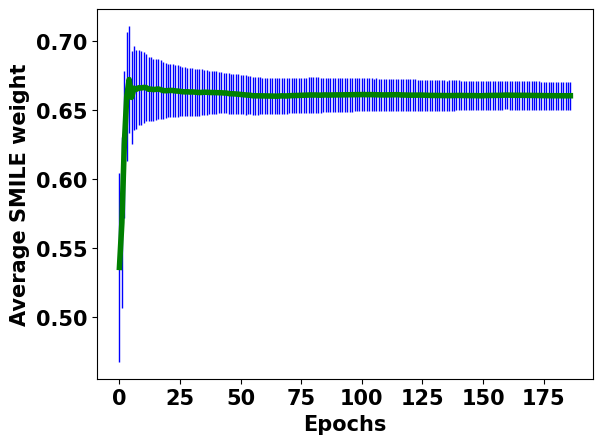

In [109]:
figure = plt.figure()
plt.errorbar(range(0, len(w1_catch)), w1_catch, w1_sd_catch, elinewidth=1, linewidth = 4, ecolor = "blue", color = "green")
# plt.legend()
plt.xlabel("Epochs", fontweight = "bold",fontsize = 15)
plt.ylabel("Average SMILE weight", fontweight = "bold", fontsize = 15)
plt.xticks(fontsize = 15, fontweight = "bold")
plt.yticks(fontsize = 15, fontweight = "bold")
figure.savefig('Plots/Avg_Smile_Weight_Tajectory.pdf', bbox_inches='tight', format = "pdf")
figure.savefig('Plots/Avg_Smile_Weight_Tajectory.png', bbox_inches='tight')
plt.show()

In [77]:
# plt.errorbar(range(0, len(weight_norm_mean)), weight_norm_mean, weight_norm_sd)

In [78]:
# cov_mat_final, _ = create_cov(smiles_feats_train.shape[0],initial_ensembles)

In [79]:
# cov_mat_final

In [80]:
# R_t

In [81]:
# np.cov(y_chk_full.values.T)

In [82]:
best_R_t

array([[   7.167281  ,  -59.79020581],
       [ -59.79020581, 3088.22405214]])

In [83]:
np.cov(y_train_cur.T)

array([[   7.15535584,  -59.64784375],
       [ -59.64784375, 3085.51412811]])

In [84]:
best_train_metrics

[array([0.0553404 , 0.95370585]),
 array([0.93045897, 0.97218359]),
 array([0.13125189, 3.15009624]),
 [0.9997865961552727, 0.9998527586317569]]

In [85]:
best_test_metrics

[array([0.06600584, 0.74224094]),
 array([0.93333333, 0.97916667]),
 array([0.133776  , 3.15184708]),
 [0.9997085613815536, 0.9998918106853658]]

In [86]:
best_mod1_weight

0.6608294647016336

In [87]:
best_mod2_weight

0.3391705352983664

In [88]:
pickle.dump(w1_catch, open('..//Data//best_w1_catch_applications_no_cholesky.pkl', 'wb'))

In [89]:
pickle.dump(w1_sd_catch, open('..//Data//best_w1_sd_catch_applications_no_cholesky.pkl', 'wb'))

In [90]:
pickle.dump(best_initial_ensembles, open('..//Data//best_initial_ensembles_applications_no_cholesky.pkl', 'wb'))

In [91]:
pickle.dump(best_G_u_test, open('..//Data//G_u_test_applications_no_cholesky.pkl', 'wb'))

In [92]:
pickle.dump(best_averaged_targets_test, open('..//Data//best_averaged_targets_test_applications_no_cholesky.pkl', 'wb'))

In [93]:
pickle.dump(y_valid_cur, open('..//Data//y_valid_cur_applications_no_cholesky.pkl', 'wb'))

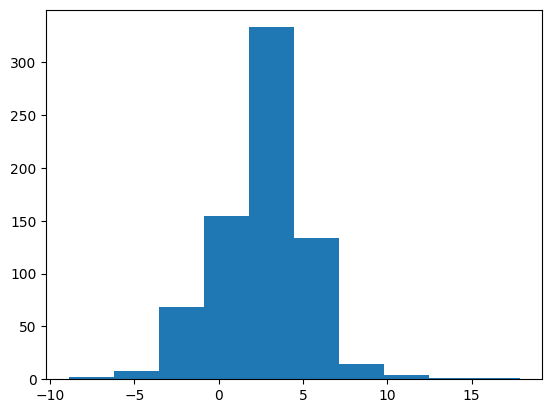

In [94]:
plt.hist(y_train_cur[:,0])
plt.show()

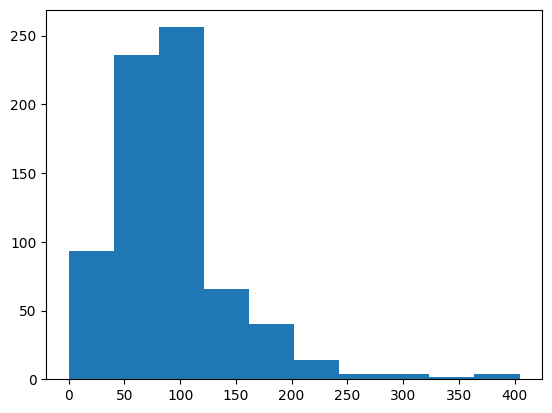

In [95]:
plt.hist(y_train_cur[:,1])
plt.show()

In [98]:
var1 = best_R_t[0,0]
var2 = best_R_t[1,1]
cov = best_R_t[1,0]

n = 32
    
ul = var1*np.identity(n)
lr = var2*np.identity(n)
ur = cov*np.identity(n)
ll = ur.T    
    
first_row = np.hstack((ul, ur))
second_row = np.hstack((ll, lr))
R_t = np.vstack((first_row, second_row))

In [100]:
# R_t

In [102]:
small_R_t = np.array([[var1, cov], [cov, var2]])

In [106]:
R_t

array([[   7.167281  ,    0.        ,    0.        , ...,   -0.        ,
          -0.        ,   -0.        ],
       [   0.        ,    7.167281  ,    0.        , ...,   -0.        ,
          -0.        ,   -0.        ],
       [   0.        ,    0.        ,    7.167281  , ...,   -0.        ,
          -0.        ,   -0.        ],
       ...,
       [  -0.        ,   -0.        ,   -0.        , ..., 3088.22405214,
           0.        ,    0.        ],
       [  -0.        ,   -0.        ,   -0.        , ...,    0.        ,
        3088.22405214,    0.        ],
       [  -0.        ,   -0.        ,   -0.        , ...,    0.        ,
           0.        , 3088.22405214]])

In [110]:
np.mean(np.kron(small_R_t, np.identity(n)) == R_t)

1.0

In [1]:
import pickle

In [2]:
best_initial_ensembles = pickle.load(open('..//Data//best_initial_ensembles_applications_no_cholesky.pkl', 'rb'))

In [3]:
best_initial_ensembles.shape

(274, 2192)